In [2]:
# ! pip install git+https://github.com/alexhernandezgarcia/gflownet-dev@catalyst
! pip install pyxtal

  Using cached pyxtal-0.6.6-py3-none-any.whl.metadata (5.4 kB)
  Using cached spglib-2.4.0-cp310-cp310-manylinux_2_17_x86_64.whl.metadata (4.2 kB)
  Using cached pymatgen-2024.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached importlib_metadata-7.1.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached monty-2024.5.15-py3-none-any.whl.metadata (2.5 kB)
  Using cached palettable-3.3.3-py2.py3-none-any.whl.metadata (3.3 kB)
  Using cached pybtex-0.24.0-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached ruamel.yaml-0.18.6-py3-none-any.whl.metadata (23 kB)
  Using cached uncertainties-3.1.7-py2.py3-none-any.whl.metadata (14 kB)
  Using cached ruamel.yaml.clib-0.2.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (2.2 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached latexcodec-3.0.0-py3-none-any.whl.metadata (4.9 kB)
Using cached pyxtal-0.6.6-py3-none-any.whl (2.8 MB)
Usin

In [3]:
from gflownet.envs.crystals import surface

In [4]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="test_ocp.yaml", overrides=[])
    print(OmegaConf.to_yaml(config))
    print(config)

# config.sampler.conf.logger.do.online = False

dataset:
  _target_: activelearning.dataset.ocp.OCPDatasetHandler
  checkpoint_path: /network/scratch/a/alexandre.duval/ocp/runs/4648581/checkpoints/best_checkpoint.pt
  data_path: /network/scratch/a/alexandre.duval/ocp/runs/4657270/deup_dataset
  normalize_labels: true
  target_mean: -1.525913953781128
  target_std: 2.279365062713623
  batch_size: 256
  train_fraction: 0.1
  shuffle: true
oracle:
  _target_: activelearning.oracle.ocp.OCPOracle
  checkpoint_path: ${dataset.checkpoint_path}
  cost: 100
sampler:
  _target_: activelearning.sampler.sampler.GreedySampler
selector:
  _target_: activelearning.selector.selector.Selector
surrogate:
  feature_extractor:
    _target_: activelearning.surrogate.feature_extractor.mlp.MLP
    n_input: 352
    n_hidden:
    - 265
    - 512
    - 265
    n_output: 16
    float_precision: ${float_precision}
  _target_: activelearning.surrogate.gp_surrogate.DeepKernelSVGPSurrogate
  train_epochs: 20
  lr: 0.01
  mll_args:
    num_data: 4059
acquisition:


/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'test_ocp.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [5]:
sampler = hydra.utils.instantiate(
    config.sampler,
    acquisition=None,
    device="cpu",
    float_precision=32,
    _recursive_=False,
)

# Active Learning Loop

In [1]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="test_ocp.yaml", overrides=[])
    print(OmegaConf.to_yaml(config))
    print(config)

# config.sampler.conf.logger.do.online = False

dataset:
  _target_: activelearning.dataset.ocp.OCPDatasetHandler
  checkpoint_path: /network/scratch/a/alexandre.duval/ocp/runs/4648581/checkpoints/best_checkpoint.pt
  data_path: /network/scratch/a/alexandre.duval/ocp/runs/4657270/deup_dataset
  normalize_labels: true
  target_mean: -1.525913953781128
  target_std: 2.279365062713623
  batch_size: 256
  train_fraction: 0.1
  shuffle: true
oracle:
  _target_: activelearning.oracle.ocp.OCPOracle
  checkpoint_path: ${dataset.checkpoint_path}
  cost: 100
sampler:
  conf:
    env:
      _target_: gflownet.envs.crystals.surface.CrystalSurface
      reward_func: identity
      reward_min: 1.0e-08
      reward_beta: 1.0
      reward_norm: 1.0
      reward_norm_std_mult: 0.0
      proxy_state_format: oracle
      skip_mask_check: false
      conditional: false
      continuous: false
      buffer:
        replay_capacity: 0
        train: null
        test: null
        data_path: null
      id: surface
      has_crystal_to_miller_constraints:

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'test_ocp.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [2]:
import torch

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = config.device
# device = "cuda"
n_iterations = 2 #config.budget  # TODO: replace with budget
n_samples = config.n_samples

from gflownet.utils.common import set_float_precision

float_prec = set_float_precision(config.float_precision)
# float_prec = set_float_precision(32)


from activelearning.utils.common import set_seeds
# Set other random seeds
# set_seeds(None)#config.seed)
ocp_checkpoint_path = config.dataset.checkpoint_path
dataset_path = config.dataset.data_path

In [3]:
from activelearning.dataset.ocp import OCPDatasetHandler
from activelearning.oracle.ocp import OCPOracle

from activelearning.surrogate.feature_extractor.mlp import MLP
from activelearning.surrogate.feature_extractor.ocp import FAENetFeatureExtractor
from activelearning.surrogate.gp_surrogate import DeepKernelSVGPSurrogate
from activelearning.acquisition.acquisition import (
    BOTorchMaxValueEntropyAcquisition,
    BOTorchMonteCarloAcquisition,
)
import botorch

from activelearning.sampler.sampler import GreedySampler, RandomSampler
from activelearning.selector.selector import Selector, ScoreSelector


# --- Dataset
dataset_handler = OCPDatasetHandler(
    ocp_checkpoint_path,
    dataset_path,
    train_fraction=0.1,
    float_precision=float_prec,
)

candidate_set, _, _ = dataset_handler.get_candidate_set()


# --- Oracle
oracle = OCPOracle(
    ocp_checkpoint_path,
    device=device,
    float_precision=float_prec,
)

best_scores = []
all_scores = {}

train_data, test_data = dataset_handler.get_dataloader()

# --- Surrogate (e.g., Bayesian Optimization, DKL)
# feature_extractor = Identity(dataset_handler.train_data.shape[-1])
# feature_extractor = MLP(
#     n_input=dataset_handler.train_data.shape[-1],
#     n_hidden=[265, 512, 265],
#     n_output=16,
#     float_precision=float_prec,
# )
feature_extractor = FAENetFeatureExtractor(
    ocp_checkpoint_path,
    device,
    [265, 512, 265],
    n_output=16,
    float_precision=float_prec,
)
feature_extractor.to(device)

# starts with a clean slate each iteration
surrogate = DeepKernelSVGPSurrogate(
    feature_extractor,
    float_precision=float_prec,
    device=device,
    mll_args={"num_data": len(train_data.dataset)},
    train_epochs=1,
    lr=0.01,
    logger=None,
)
surrogate.fit(train_data)

# acq_fn = BOTorchMaxValueEntropyAcquisition(
#     surrogate.model, device=device, float_precision=float_prec
# )
acq_fn = BOTorchMonteCarloAcquisition(
    surrogate.model,
    acq_fn_class=botorch.acquisition.monte_carlo.qExpectedImprovement,
    dataset_handler=dataset_handler,
    device=device,
    float_precision=float_prec,
)

please install gflownet to use the branin proxy
please install gflownet to use the hartmann proxy
depfaenet is2re


Heads up: cat-ads edges being removed!
🗑️ Setting dropout_lin for output block to 0.3
⛄️ No layer to freeze

depfaenet is2re


Heads up: cat-ads edges being removed!
🗑️ Setting dropout_lin for output block to 0.0
⛄️ No layer to freeze

Loading checkpoint from: /network/scratch/a/alexandre.duval/ocp/runs/4648581/checkpoints/best_checkpoint.pt onto cuda:0
depfaenet is2re


Heads up: cat-ads edges being removed!
🗑️ Setting dropout_lin for output block to 0.0
⛄️ No layer to freeze

Loading checkpoint from: /network/scratch/a/alexandre.duval/ocp/runs/4648581/checkpoints/best_checkpoint.pt onto cuda:0


/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
Epoch: 100%|██████████| 1/1 [00:10<00:00, 10.80s/it, loss=1.54]


In [5]:

# --- Sampler (e.g., GFlowNet, or Random Sampler)
sampler = hydra.utils.instantiate(
    config.sampler,
    acquisition=acq_fn,
    device=device,
    float_precision=float_prec,
    _recursive_=False,
)



            Important: offline trajectories will NOT be sampled. In order to sample
            offline trajectories, the train configuration of the buffer should be
            complete and feasible and an output pkl file should be defined in
            env.buffer.train.output_pkl.
            

            Important: test metrics will NOT be computed. In order to compute
            test metrics the test configuration of the buffer should be complete and
            feasible and an output pkl file should be defined in
            env.buffer.test.output_pkl.
            


In [9]:
sampler.sampler.env

In [6]:
sampler.fit()  # only necessary for samplers that train a model

  0%|          | 0/500 [00:00<?, ?it/s]


TypeError: cannot pickle 'Environment' object

In [ ]:

samples, sample_idcs = sampler.get_samples(
    n_samples * 5, candidate_set=candidate_set  # .clone().to(device)
)

# --- Selector
selector = ScoreSelector(
    acq_fn,
    device=device,
    float_precision=float_prec,
    maximize=False
)
selected_samples, selected_idcs = selector(
    n_samples=n_samples, candidate_set=samples, index_set=sample_idcs
)

oracle_samples = dataset_handler.prepare_dataset_for_oracle(
    selected_samples, selected_idcs
)

scores = oracle(oracle_samples).cpu()
dataset_handler.update_dataset(oracle_samples.cpu(), scores)

depfaenet is2re


Heads up: cat-ads edges being removed!
🗑️ Setting dropout_lin for output block to 0.3
⛄️ No layer to freeze

depfaenet is2re


Heads up: cat-ads edges being removed!
🗑️ Setting dropout_lin for output block to 0.0
⛄️ No layer to freeze

Loading checkpoint from: /network/scratch/a/alexandre.duval/ocp/runs/4648581/checkpoints/best_checkpoint.pt onto cuda:0
--iteration 0 - training on 4059 instances


/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
Epoch: 100%|██████████| 2/2 [00:19<00:00,  9.80s/it, loss=1.53]


top_score: tensor(-1.6313)
mean_topk_score: tensor(-0.0076)
best_score: tensor(-1.6313)
median_score: tensor(-0.0582)
mean_score: tensor(-0.0076)
worst_score: tensor(2.0850)
scores: tensor([ 0.1002,  0.0877, -0.5412,  0.1341, -0.8474,  0.3240,  1.8136,  0.2481,
         0.9837, -0.8574,  0.2340, -0.0908,  1.7557, -0.3602, -0.1020, -0.5773,
         0.7554, -0.8241, -0.1068, -1.3886,  0.0547, -0.3436, -0.7655, -0.0434,
         0.9693,  1.2347,  1.9166, -0.4472,  1.2546,  0.3858, -1.4409, -0.4957,
         0.9188,  0.1769, -0.4741,  0.2329,  0.4068, -0.4173, -0.4009, -1.2427,
        -0.4462,  0.4546, -0.7023, -0.0651, -0.3211, -1.0914, -0.0040,  0.4325,
        -1.6313,  1.6873,  0.1584,  0.3865, -0.0582, -0.1933, -0.0181, -0.8725,
        -0.2377,  1.0245,  1.1320, -0.9266, -0.2312,  0.0728,  1.7421,  1.2134,
        -0.5538,  0.4374, -0.3326,  0.6141, -0.0172,  0.6896, -0.4165, -1.0363,
         0.3541, -0.4447, -1.3506,  0.3436, -0.4219,  0.4570, -0.9395,  0.0659,
        -1.5676,  

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0268], device='cuda:0', dtype=torch.float64), std = tensor([0.9127], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
Epoch:   0%|          | 0/2 [00:02<?, ?it/s, loss=1.7] 


KeyboardInterrupt: 

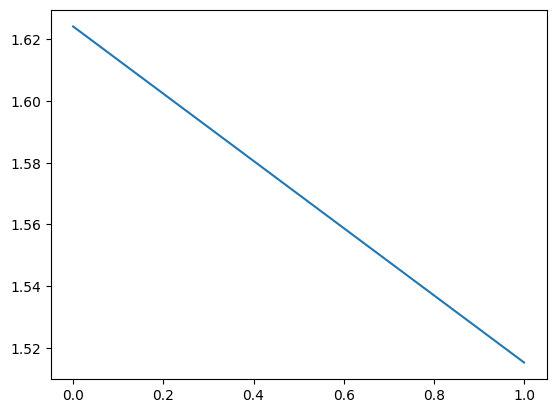

In [ ]:
from activelearning.dataset.ocp import OCPDatasetHandler
from activelearning.oracle.ocp import OCPOracle

from activelearning.surrogate.feature_extractor.mlp import MLP
from activelearning.surrogate.gp_surrogate import DeepKernelSVGPSurrogate
from activelearning.acquisition.acquisition import (
    BOTorchMaxValueEntropyAcquisition,
    BOTorchMonteCarloAcquisition,
)
import botorch

from activelearning.sampler.sampler import GreedySampler, RandomSampler
from activelearning.selector.selector import Selector, ScoreSelector


# --- Dataset
dataset_handler = OCPDatasetHandler(
    ocp_checkpoint_path,
    dataset_path,
    train_fraction=0.1,
    float_precision=float_prec,
)

from activelearning.utils.logger import WandBLogger, ConsoleLogger

# logger = WandBLogger(project_name="test_ocp_training", run_name="greedy_epochs-10_samples-100_ei")
logger = ConsoleLogger(
    project_name="test_ocp_training", run_name="greedy_epochs-10_samples-100_ei"
)
# logger = None

from activelearning.utils.plotter import OCPCIME4RExportHelper

# plotter = OCPCIME4RExportHelper(dataset_handler, device=device)
plotter = None

candidate_set, _, _ = dataset_handler.get_candidate_set()


# --- Oracle
oracle = OCPOracle(
    ocp_checkpoint_path,
    device=device,
    float_precision=float_prec,
)
if plotter is not None:
    oracle_dataloader = dataset_handler.prepare_oracle_dataloader(dataset_handler.candidate_data)
    plotter.plot_function(
        oracle,
        oracle_dataloader, 
        label="oraclefn",
        fig="",
        ax="",
    )

best_scores = []
all_scores = {}

for i in range(n_iterations):
    train_data, test_data = dataset_handler.get_dataloader()
    print("--iteration", i, "- training on", len(train_data.dataset), "instances")

    # --- Surrogate (e.g., Bayesian Optimization, DKL)
    # feature_extractor = Identity(dataset_handler.train_data.shape[-1])
    feature_extractor = MLP(
        n_input=dataset_handler.train_data.shape[-1],
        n_hidden=[265, 512, 265],
        n_output=16,
        float_precision=float_prec,
    )
    feature_extractor.to(device)

    # starts with a clean slate each iteration
    surrogate = DeepKernelSVGPSurrogate(
        feature_extractor,
        float_precision=float_prec,
        device=device,
        mll_args={"num_data": len(train_data.dataset)},
        train_epochs=2,
        lr=0.01,
        logger=logger,
    )
    surrogate.fit(train_data)

    if plotter is not None:
        plotter.plot_function(
            surrogate.get_predictions,
            candidate_set,
            output_index=0,
            fig="",
            ax="",
            label="pred_target_mean",
            iteration=i,
        )
        plotter.plot_function(
            surrogate.get_predictions,
            candidate_set,
            output_index=1,
            fig="",
            ax="",
            label="pred_target_var",
            iteration=i,
        )

    # acq_fn = BOTorchMaxValueEntropyAcquisition(
    #     surrogate.model, device=device, float_precision=float_prec
    # )
    acq_fn = BOTorchMonteCarloAcquisition(
        surrogate.model,
        acq_fn_class=botorch.acquisition.monte_carlo.qExpectedImprovement,
        dataset_handler=dataset_handler,
        device=device,
        float_precision=float_prec,
    )
    if plotter is not None:
        plotter.plot_function(
            acq_fn,
            candidate_set,
            fig="",
            ax="",
            label="acq",
            iteration=i,
        )

    # --- Sampler (e.g., GFlowNet, or Random Sampler)
    # also starts with a clean slate; TODO: experiment with NOT training from scratch
    # sampler = RandomSampler(acq_fn, device=device)
    # sampler = GreedySampler(
    #     acq_fn,
    #     device=device,
    #     float_precision=float_prec,
    # )
    sampler = hydra.utils.instantiate(
        config.sampler,
        acquisition=acq_fn,
        device=device,
        float_precision=float_prec,
        _recursive_=False,
    )

    sampler.fit()  # only necessary for samplers that train a model

    samples, sample_idcs = sampler.get_samples(
        n_samples * 5, candidate_set=candidate_set  # .clone().to(device)
    )

    # --- Selector
    selector = Selector(
        device=device,
        float_precision=float_prec,
    )
    # selector = ScoreSelector(
    #     acq_fn,
    #     device=device,
    #     float_precision=float_prec,
    #     maximize=False
    # )
    selected_samples, selected_idcs = selector(
        n_samples=n_samples, candidate_set=samples, index_set=sample_idcs
    )

    oracle_samples = dataset_handler.prepare_dataset_for_oracle(
        selected_samples, selected_idcs
    )

    scores = oracle(oracle_samples).cpu()
    dataset_handler.update_dataset(oracle_samples.cpu(), scores)
    best_scores.append(scores.min())
    all_scores[i] = scores
    if logger is not None:
        scores_flat = torch.stack(list(all_scores.values())).flatten()
        logger.log_metric(scores_flat.min(), "top_score")
        mean_top_k = (scores_flat
            .topk(n_samples, largest=False)
            .values.mean()
        )
        logger.log_metric(mean_top_k, "mean_topk_score")
        logger.log_metric(scores.min(), "best_score")
        logger.log_metric(torch.median(scores), "median_score")
        logger.log_metric(torch.mean(scores), "mean_score")
        logger.log_metric(scores.max(), "worst_score")
        logger.log_metric(scores, "scores")

        logger.log_step(i)
    
    if plotter is not None:
        plotter.plot_scores(selected_idcs, scores, i+1)

if logger is not None:
    import matplotlib.pyplot as plt

    plt.boxplot(all_scores.values(), labels=all_scores.keys())
    plt.ylim(top=50, bottom=-50)
    logger.log_figure(plt, "all_scores")
    logger.end()

if plotter is not None:
    plotter.end(filename="ocp.csv")
best_scores